In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

import bo  # for matplotlib styling

In [2]:
xs = torch.linspace(0, 10, 101).unsqueeze(1)

train_x = torch.tensor([[0.5], [1.0], [1.5], [3], [4]])
train_y = torch.tensor([0.0625, 0.25, 0.375, 2.25, 4])

In [3]:
def visualize_gp_belief(model, likelihood):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()
    plt.figure(figsize=(8, 6))
    plt.scatter(train_x, train_y, marker="x", c="k", label="observation")
    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )
    plt.legend(fontsize=15)

## Using the zero-mean as the base strategy

In [4]:
class ConstantMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

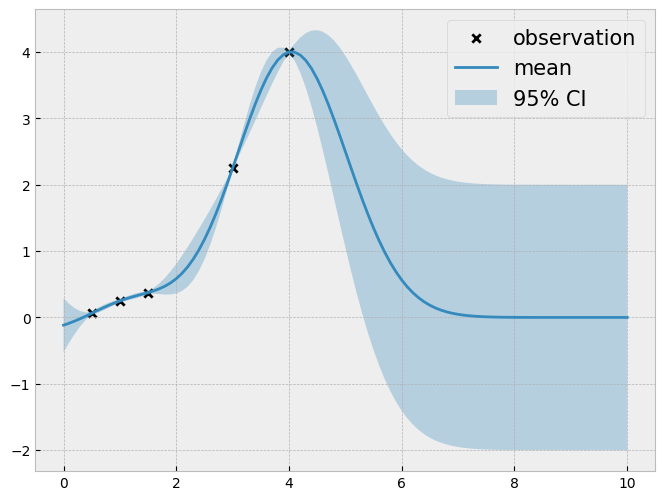

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConstantMeanGPModel(train_x, train_y, likelihood)
model.covar_module.lengthscale = 1
model.likelihood.noise = 1e-4
# model.mean_module.constant = 2
model.eval()
likelihood.eval()
visualize_gp_belief(model, likelihood)

## Using the constant function with gradient descent

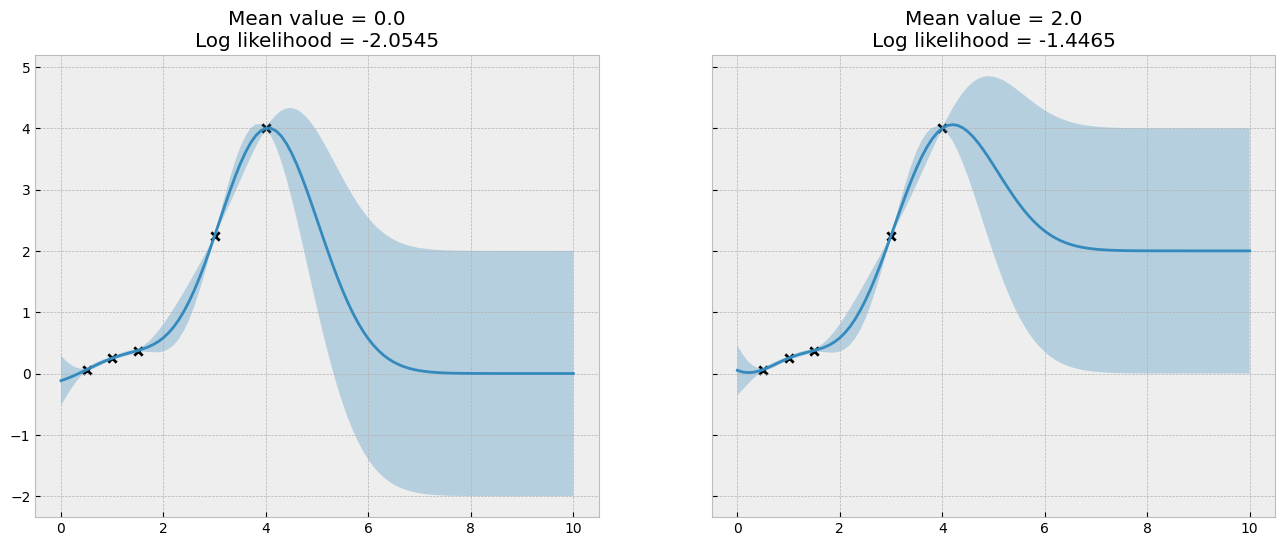

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# First panel
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")
ax[0].plot(xs, predictive_mean, label="mean")
ax[0].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)
model.eval()
likelihood.eval()

ax[0].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

# Second panel
model.mean_module.constant = 2  # torch.nn.Parameter(torch.tensor(2.0))

with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[1].scatter(train_x, train_y, marker="x", c="k", label="observations")

ax[1].plot(xs, predictive_mean, label="mean")
ax[1].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)

model.eval()
likelihood.eval()

ax[1].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

plt.show()

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ConstantMeanGPModel(train_x, train_y, likelihood)
model.covar_module.lengthscale = 1
model.likelihood.noise = 1e-4
model.eval()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam([model.mean_module.constant], lr=0.01)

# Enable the training mode.
model.train()
likelihood.train()

losses = []
constants = []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    losses.append(loss.item())
    constants.append(model.mean_module.constant.item())
    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

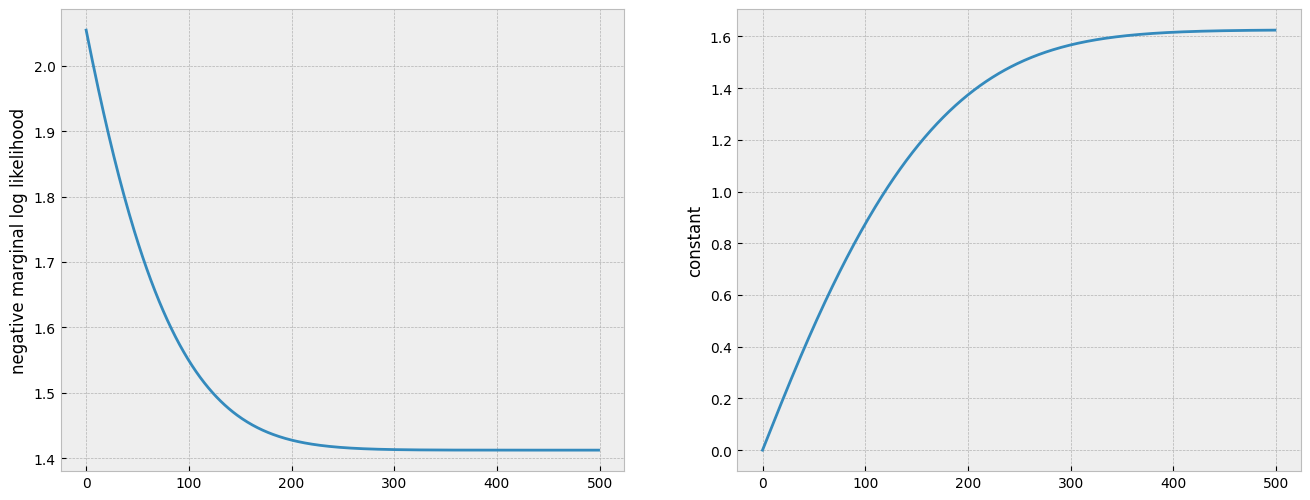

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(constants)
ax[1].set_ylabel("constant");

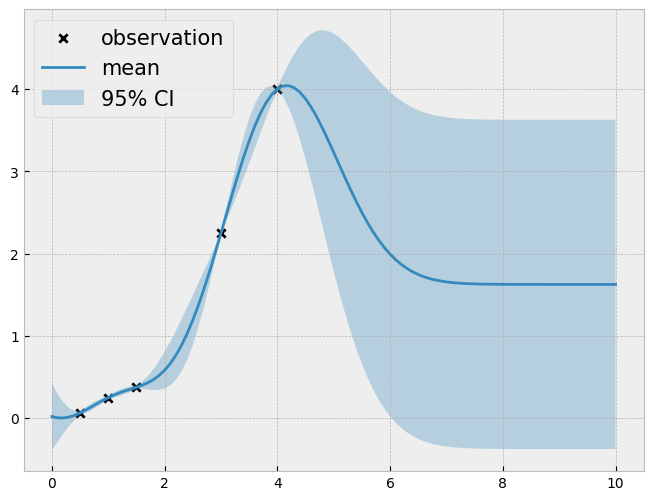

In [9]:
visualize_gp_belief(model, likelihood)

## Using the linear function with gradient descent

In [10]:
class LinearMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(1)
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = LinearMeanGPModel(train_x, train_y, likelihood)

model.covar_module.lengthscale = 1
model.likelihood.noise = 1e-4

In [12]:
optimizer = torch.optim.Adam(model.mean_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
weights = []
biases = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    weights.append(model.mean_module.weights.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

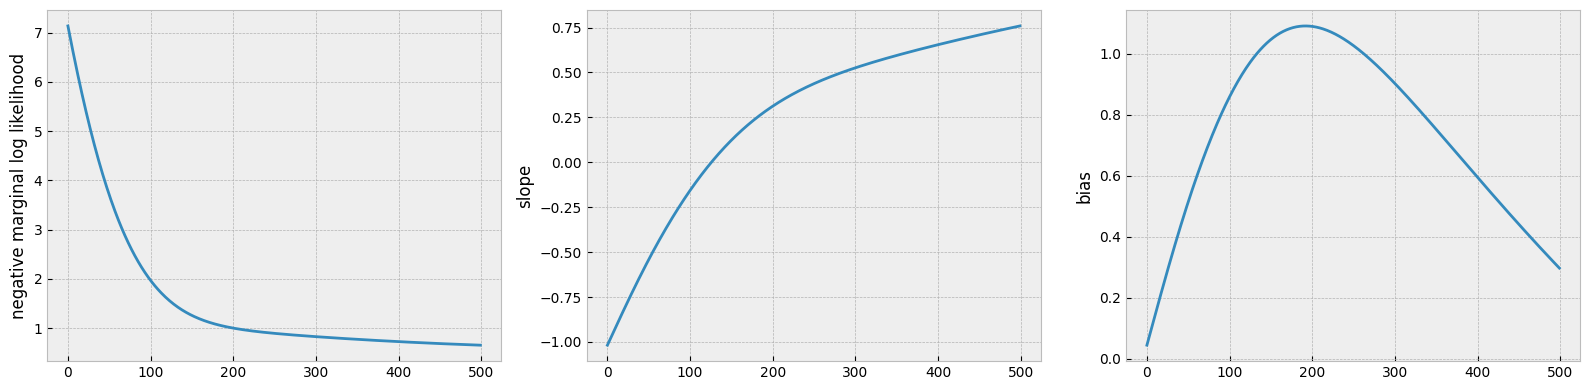

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(weights)
ax[1].set_ylabel("slope")

ax[2].plot(biases)
ax[2].set_ylabel("bias")

plt.tight_layout();

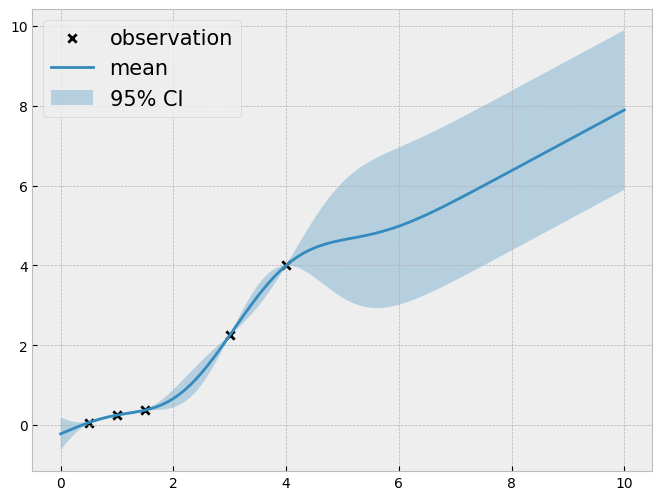

In [14]:
visualize_gp_belief(model, likelihood)